In [1]:
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1024,
        'height': 768,
        'scroll': True,
})
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 8]

# Week 11, ASTR 596: Fundamentals of Data Science


## Trees and Forests

### Gautham Narayan 
##### <gsn@illinois.edu>

## <center> Thoughts on FInal Group Project Policy? </center>
    
### HW8 today -  start working on this one earlier than the day before it's due.

## Recap

### Terminology from last class
- supervised vs unsupervised learning
- features and samples
- training vs test set
- k-fold cross validation

<img src="ul_vs_sl5.png">

<img src="ul_vs_sl6.png">

<img src="ul_vs_sl7.png">

## Decision Tree Methods

The hierarchical application of decision boundaries lead to decision trees

Tree structure:

- top node contains the entire data set
- at each branch the data are subdivided into **two** child nodes (this is the decision)
- split is based on a predefined decision boundary (usually axis aligned)
- splitting repeats, recursively, until we reach a predefined stopping criteria

There is not one decision tree algorithm - several different versions.


Broadly though, people use two algorithms:
- Iterative Dichotomiser 3 (ID3)
- Classification and Regression Trees (CART) 
ID3 is older and simpler, but straightforward to build your own implementation of so it still hangs on. Most actual research is with CART

Application of the tree to classification is simple (a series of binary decisions). 

The fraction of points from the training set classified as one class or the other defines the class associated with the decision.

## OK, so how to pick what decision to make? 

i.e. How do we choose the best attribute to divide the data set on

You need a **metric** to measure how good your feature is at predicting the desired output

`sklearn` gives you two options
- Entropy
    - and a related quantity, the Information Gain
- Gini index

We are performing top-down search through the space of possible decision trees, and optimizing this metric

## Entropy:

The entropy (we've seen this before):
\begin{equation}
\huge
H(S)=\sum_{i=1}^{c}-p_{i} \log _{2} p_{i}
\end{equation}

If you imagine a system with two states $S$ (+) and (-) then visually:

<img src="entropy_twoclass.png">

States with low entropy having high *purity* - they're more homogenous 

If a state has an entropy that is greater than zero, you can keep trying to make decisions - i.e. split further



In [2]:
# You can compute the entropy with scipy pretty easily, but practically you won't have to do this manually
import scipy.stats as st
pick1 = np.arange(0, 8, 1)
for p1 in pick1:
    p2 = 14 - p1
    print(f'Entropy for {p1, p2}: {st.entropy([p1,p2], base=2):.2f}')


Entropy for (0, 14): 0.00
Entropy for (1, 13): 0.37
Entropy for (2, 12): 0.59
Entropy for (3, 11): 0.75
Entropy for (4, 10): 0.86
Entropy for (5, 9): 0.94
Entropy for (6, 8): 0.99
Entropy for (7, 7): 1.00


And the 
## Information gain:

in terms of the Entropy


\begin{equation}
\huge
I(\text{parent}, \text{child})=H(\text{parent})-H(\text{parent}|\text{child})
\end{equation}

The second term has two values since each parent node in the decision tree has two children - weight by fraction of the population at each child (default - there are other weighting schemes).


You can measure the entropy with a log of any base, but 2 is conventional because in that case, the entropy is in units of *binary digits* or **bits.** 

This can be directly interpreted in the information processing sense as the number of bits required to represent the event. 

This quantity is also often called the **Kullback Leibler divergence** or just **KL divergence**

\begin{equation}
\huge
I(\text{parent}, \text{child})=H(\text{parent})-H(\text{parent}|\text{child})
\end{equation}

# <center> This is a distance </center>

This is really what we are specifying with all ML algorithms

Note the difference with what we did earlier
* with parameteric methods, you defined the model in terms of parameters you knew were interesting
    * and wrote down a likelihood which is a distance between your model and some of the observations (a training set)

* With non-parametric methods, you didn't define a model, but you did define some basis (sines or Gaussians but many other options) 
    * expressed in terms of the variable you decided were interesting (time/position/whatever)
        * and wrote down a form for the correlation between different values of that variable - the kernel
            * you held out some of your observations as a training set 
                * which let you compute a covariance matrix given your kernel 
                    * which let you write down a likelihood which is a distance between the conditioned model and the training set

* Now you aren't even defining what the variables in the model are, but you are defining a measure of importance that can be used to weight each state in your model
    * and a form for the distance between two states in terms of infromation that is gained or loss - a **loss function**
        * and you hold out some of your observations as a training set
            * and minimize the loss function to condition the model
                * which in supervised learning is reducing the entropy at each node 
                    (i.e. making decisions such that the output is a more homogenous subset)
                    

## Gini Impurity

1. Randomly pick a datapoint in our dataset
2. Randomly classify it according to the class distribution in the dataset
    (i.e. if you 6 red, 2 green, 3 blue things in some dataset with 11 samples, then (6/11, 2/11 and 3/11 respectively)
    
### What’s the probability we classify the datapoint (in)correctly? 

The answer to that question is the Gini (Im)purity.

\begin{equation}
\huge
G(S)=\sum_{i=1}^{C} p(i) \cdot(1-p(i))
\end{equation}

And the Gini gain

\begin{equation}
\huge
I(\text{parent}, \text{child})=G(\text{parent})-G(\text{parent}|\text{child})
\end{equation}

Yup. This is a distance.


## In-class exercise 

#### Look at the table below and pick the feature that is best to split on first

#### Remember that you only get to make a binary split (i.e. mild or not mild)

In [3]:
# RUN THIS
import astropy.table as at
import graphviz 
weather = at.Table.read('weather_nominal.csv', format='ascii')
weather

outlook,temperature,humidity,windy,play
str8,str4,str6,str5,str3
sunny,hot,high,FALSE,no
sunny,hot,high,TRUE,no
overcast,hot,high,FALSE,yes
rainy,mild,high,FALSE,yes
rainy,cool,normal,FALSE,yes
rainy,cool,normal,TRUE,no
overcast,cool,normal,TRUE,yes
sunny,mild,high,FALSE,no
sunny,cool,normal,FALSE,yes


# Implementing a Single Decision Tree

In [4]:
# RUN THIS

from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# convert the labels to numerical data
cols = []
new_weather = weather.copy()
for i, feature in enumerate(weather.colnames):
    le = preprocessing.LabelEncoder()
    new_weather[feature] = le.fit_transform(weather[feature])*1.
new_weather = new_weather.to_pandas()
new_weather

,outlook,temperature,humidity,windy,play
0,2.0,1.0,0.0,0.0,0.0
1,2.0,1.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,1.0
3,1.0,2.0,0.0,0.0,1.0
4,1.0,0.0,1.0,0.0,1.0
5,1.0,0.0,1.0,1.0,0.0
6,0.0,0.0,1.0,1.0,1.0
7,2.0,2.0,0.0,0.0,0.0
8,2.0,0.0,1.0,0.0,1.0
9,1.0,2.0,1.0,0.0,1.0


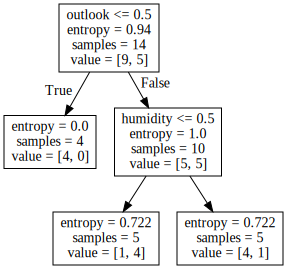

In [5]:
# get the training features and target
X_train = new_weather[weather.colnames[0:4]]
Y_train = 1.-new_weather['play']

# TWO LINES OF CODE TO IMPLEMENT A DECISION TREE

# build the decision tree
clf = DecisionTreeClassifier(max_depth = 2, criterion='entropy')

# Step 3: Train the model on the data
clf.fit(X_train, Y_train)

# Plot the Tree
dot_data = tree.export_graphviz(clf, feature_names= weather.colnames[0:4], out_file=None) 
graph = graphviz.Source(dot_data)
graph

Decision trees are simple to interpret (a set of questions).

[This structure is called a Dendrogram](https://en.wikipedia.org/wiki/Dendrogram)

<img src="tree_components.png">

Remember the bias-variance tradeoff?
<img src="overfitting_underfitting_cartoon.png">

# There's not a lot you can do with a tree structure:
<img src="tree_depth.png">

## Limiting Model Complexity
<img src="tree_limit.png">

## Pruning - getting rid of leaves that don't have large information/gini gain
<img src="tree_pruning.png">

# In-class exercise: Predicting Survival from the Titanic Sinking

This is the "Hello World" of Kaggle challenges.

<img src="titanic-sinking-hoyt.jpg">

We'll read in the file `titanic_train.csv`

Here's a description of the columns
<img src="titanic_data.png">

Pick columns (i.e. features) that you think might have an impact on survival

**CAUTION**: Some of these features may be missing for some samples - i.e. there is missing data for some people - if you use astropy (> 4.0) it will construct a table with masked columns. If you use an older astropy or pandas, this is your problem. Irrespective, drop samples with NaN values. There should be 714 passengers after that. 

# BUILD A DECISION TREE AND TELL ME WHAT VARIABLES ARE IMPORTANT 

In [6]:
# RUN THIS

%matplotlib inline
from astropy.visualization import hist
import sklearn
from sklearn import metrics

In [7]:
# RUN THIS

# Read in the data
train = at.Table.read('titanic_train.csv', format='ascii')

# mask out rows that are NaNs
train = train[~train['Age'].mask]

# Look at the data
train

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
int64,int64,int64,str82,str6,float64,int64,int64,str18,float64,str15,str1
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,--,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.925,--,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.05,--,S
7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.075,--,S
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,--,S
10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,--,C


In [8]:
# YOUR CODE HERE
X_train = train['Pclass', 'Sex', 'Age']
X_train['Pclass'] = np.array(X_train['Pclass']).astype('f8')
X_train['Sex'] = [1. if s =='female' else 0. for s in train['Sex']]

Y_train = np.array(train['Survived']).astype('f8')
X_train = X_train.to_pandas()


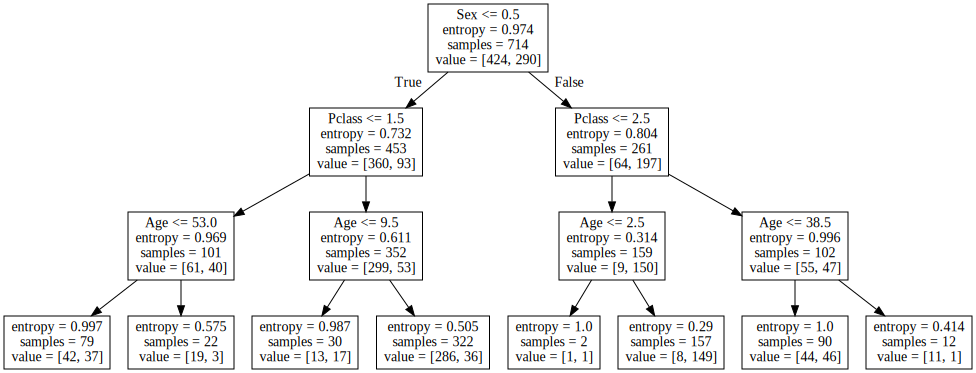

In [9]:

# TWO LINES OF CODE TO IMPLEMENT A DECISION TREE

# build the decision tree
clf = DecisionTreeClassifier(max_depth = 3, criterion='entropy')

# Step 3: Train the model on the data
clf.fit(X_train, Y_train)

# Plot the Tree
dot_data = tree.export_graphviz(clf, feature_names= ['Pclass', 'Sex', 'Age'], out_file=None) 
graph = graphviz.Source(dot_data)
graph

## Regression with Trees: When the target variable is nominal 

<img src="tree_regression.png">

## But you say 

### AH BUT ENTROPY AND GINI IMPURITY ARE DEFINED AS MARGINALS OVER CATEGORICAL VARIABLES, WOE IS ME HOW COULD THESE DISTANCE METRICS EVER POSSIBLY WORK FOR VARIABLES THAT ARE CONTINUOUS 

(Well ok maybe you don't say exactly that, but this is what I say when the dog breaks my favorite coffee cup with my coffee still in it)


<img src="tree_regression_metric.png">

Hello old friends.

## The big issues with trees

* Variance - different trees lead to different results
    - intuitively if you have just two continuous variables, then calculating the split for every node even with a depth = 2 tree is of order $\infty^2$
    
You can view each tree as a single path that you can take do get the desired outcome.

There are many possible paths, so we do the thing we always do and marginalize over them.

In other words, go from a single decision tree to a many decision trees.


## Ensemble Methods: Bagging

Run multiple different models on the same data and learn from the ensemble

We can improve the performance of decisions trees (especially when there are many features) by **bagging** (Bootstrap AGGregation). This averages the predictive results of a series of bootstrap samples.

For a sample of $N$ points in a training set, bagging generates $K$ equally sized bootstrap samples from which to estimate the function $f_i(x)$. The final estimator, defined by bagging, is then

\begin{equation}
\huge
f(x)=\frac{1}{K} \sum_{i}^{K} f_{i}(x)
\end{equation}


(Yep, this is just take the average of all the individual methods)

## Ensemble Methods: Boosting

Boosting is an ensemble approach motivated by the idea that combining many weak classifiers can result in an improved classification. 

Boosting creates models to attempt to correct the errors of the ensemble so far 
**i.e. we reweight the data based on how incorrectly the data were classified in the previous iteration.**

- if you have $N$ data points in your sample with features $x$, and target $y$

\begin{equation}
\large
x_{i} \in \mathbb{R}^{d}, y_{i} \in\{-1,1\}
\end{equation}
**initalize the weights to $1/N$**

- Run the classification $h$ (i.e. hypotheses) with a weak clasifier $t$ times and compute the weighted classification error for each classifier

\begin{equation}
\large
\epsilon = \frac{\sum_{i=1}^{N} w_{i} I\left(y_{i} \neq h_{j}\left(x_{i}\right)\right)}{\sum_{i=1}^{N} w_{i}}
\end{equation}

where $I$ is the indicator variable (1 if $y_i$ matches the hypotheses, 0 if not).

- The weight for each weak classifier is related to the weighted classification error

\begin{equation}
\large
\theta_{t}=\frac{1}{2} \ln \left(\frac{1-\epsilon_{t}}{\epsilon_{t}}\right)
\end{equation}

- each time reweight each sample $i$ based on the previous performance of the classifier $t$

For any classifier with accuracy higher than 50%, the weight is positive. 
The more accurate the classifier, the larger the weight.
For a classifer with less than 50% accuracy, the weight is negative.

\begin{equation}
\large
w_{t+1}=\frac{w_{t} \exp \left[-\theta_{t} y_{i} h_{t} \right]}{Z_{t}}
\end{equation}
        
Where the denominator is the normalization constant to make the sum of the weights 1. 

If a misclassified case is from a positive weighted classifier, the “exp” term in the numerator would be always larger than 1. 

**NOTE THAT A WEAK CLASSIFIER WITH A NEGATIVE WEIGHT STILL CONTRIBUTES**
(you can be wrong, but if you are wrong consistently, then you are still useful)

You can view this as just iteratively minimizing the exponential loss function

\begin{equation}
\huge
L(y, F(x))=E\left(e^{-y F(x)}\right)
\end{equation}

where $E$ is just weighted expectation value.

[I'll spare you the math](https://towardsdatascience.com/boosting-algorithm-adaboost-b6737a9ee60c)

- At the end of this procedure we allow the classifiers a weighted vote on the final classification

\begin{equation}
\huge
H(x)=\operatorname{sign}\left(\sum_{t=1}^{T} \theta_{t} h_{t}(x)\right)
\end{equation}

    
The most popular form of boosting is that of adaptive boosting (helpfully implemented in a package called **AdaBoost**)

A fundamental limitation of the boosted decision tree is the computation time for large data sets (they rely on a chain of classifiers).

Two common ensemble methods that use decision trees:

1. Random Forests
    - Trees run in parallel, independent of each other
    - Each tree uses a random subset of the observations and features (**bagging**)
        - the number of features selected per split level is typically limited to the square root of the total number of features
    - Class predicted by majority vote - what class do most trees think an observation belongs to or average in the case of regression



2. Gradient Boosted Trees
    - Trees run in series 
    - Each tree uses different weights for the features, updating the weights from the previous tree
    - The last tree makes the prediction

# The textbook has a couple of examples of using Random Forests and BDTs for regression using SDSS galaxies with known redshifts (the target) and magnitudes as features - i.e. a photo-z estimator.

@pickle_results: using precomputed results from 'photoz_forest.pkl'


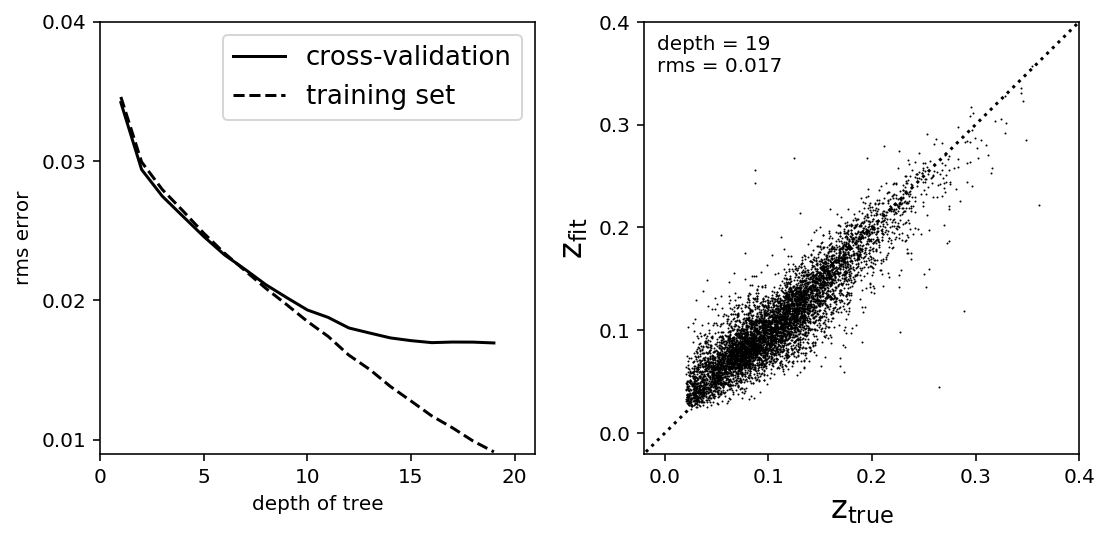

In [10]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from astroML.datasets import fetch_sdss_specgals
from astroML.decorators import pickle_results

#------------------------------------------------------------
# Fetch and prepare the data
data = fetch_sdss_specgals()

# put magnitudes in a matrix
mag = np.vstack([data['modelMag_%s' % f] for f in 'ugriz']).T
z = data['z']

# train on ~60,000 points
mag_train = mag[::10]
z_train = z[::10]

# test on ~6,000 distinct points
mag_test = mag[1::100]
z_test = z[1::100]


#------------------------------------------------------------
# Compute the results
#  This is a long computation, so we'll save the results to a pickle.
@pickle_results('photoz_forest.pkl')
def compute_photoz_forest(depth):
    rms_test = np.zeros(len(depth))
    rms_train = np.zeros(len(depth))
    i_best = 0
    z_fit_best = None

    for i, d in enumerate(depth):
        clf = RandomForestRegressor(n_estimators=10,max_features=3,
                                    max_depth=d, random_state=0)
        clf.fit(mag_train, z_train)

        z_fit_train = clf.predict(mag_train)
        z_fit = clf.predict(mag_test)
        rms_train[i] = np.mean(np.sqrt((z_fit_train - z_train) ** 2))
        rms_test[i] = np.mean(np.sqrt((z_fit - z_test) ** 2))

        if rms_test[i] <= rms_test[i_best]:
            i_best = i
            z_fit_best = z_fit

    return rms_test, rms_train, i_best, z_fit_best


depth = np.arange(1, 20)
rms_test, rms_train, i_best, z_fit_best = compute_photoz_forest(depth)
best_depth = depth[i_best]

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(8, 4))
fig.subplots_adjust(wspace=0.25,
                    left=0.1, right=0.95,
                    bottom=0.15, top=0.9)

# left panel: plot cross-validation results
ax = fig.add_subplot(121)
ax.plot(depth, rms_test, '-k', label='cross-validation')
ax.plot(depth, rms_train, '--k', label='training set')
ax.legend(loc=1, prop=dict(size=13))

ax.set_xlabel('depth of tree')
ax.set_ylabel('rms error')

ax.set_xlim(0, 21)
ax.set_ylim(0.009,  0.04)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.01))

# right panel: plot best fit
ax = fig.add_subplot(122)
ax.scatter(z_test, z_fit_best, s=1, lw=0, c='k')
ax.plot([-0.1, 0.4], [-0.1, 0.4], ':k')
ax.text(0.03, 0.97, "depth = %i\nrms = %.3f" % (best_depth, rms_test[i_best]),
        ha='left', va='top', transform=ax.transAxes)

ax.set_xlabel(r'$\rm z_{true}$', fontsize=16)
ax.set_ylabel(r'$\rm z_{fit}$', fontsize=16)

ax.set_xlim(-0.02, 0.4001)
ax.set_ylim(-0.02, 0.4001)
ax.xaxis.set_major_locator(plt.MultipleLocator(0.1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))

plt.show()

@pickle_results: using precomputed results from 'photoz_boosting.pkl'


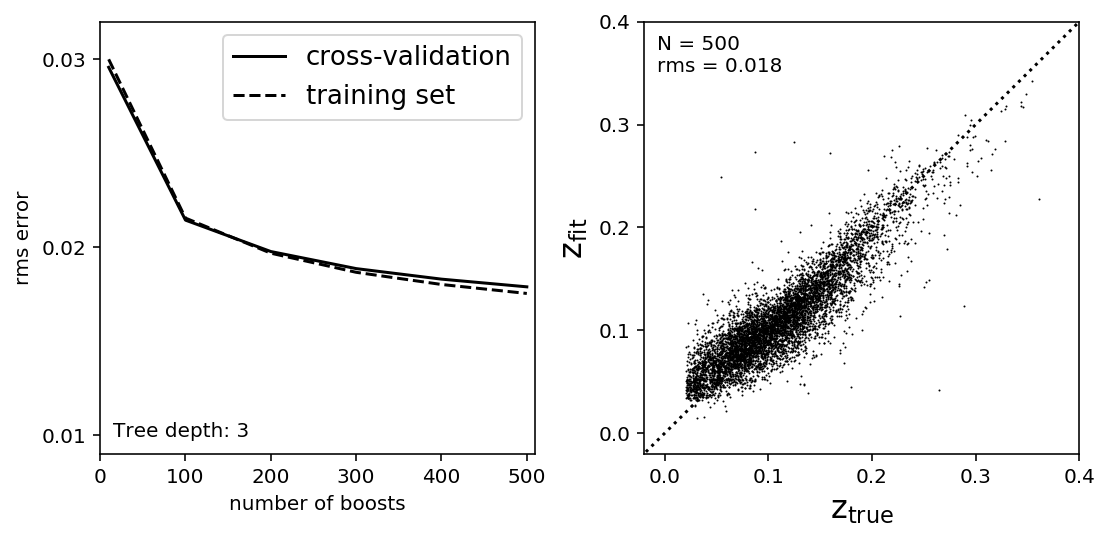

In [11]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.ensemble import GradientBoostingRegressor
from astroML.datasets import fetch_sdss_specgals
from astroML.decorators import pickle_results

#------------------------------------------------------------
# Fetch and prepare the data
data = fetch_sdss_specgals()

# put magnitudes in a matrix
mag = np.vstack([data['modelMag_%s' % f] for f in 'ugriz']).T
z = data['z']

# train on ~60,000 points
mag_train = mag[::10]
z_train = z[::10]

# test on ~6,000 distinct points
mag_test = mag[1::100]
z_test = z[1::100]


#------------------------------------------------------------
# Compute the results
#  This is a long computation, so we'll save the results to a pickle.
@pickle_results('photoz_boosting.pkl')
def compute_photoz_forest(N_boosts):
    rms_test = np.zeros(len(N_boosts))
    rms_train = np.zeros(len(N_boosts))
    i_best = 0
    z_fit_best = None

    for i, Nb in enumerate(N_boosts):
        clf = GradientBoostingRegressor(n_estimators=Nb, learning_rate=0.1,
                                        max_depth=3, random_state=0)
        clf.fit(mag_train, z_train)

        z_fit_train = clf.predict(mag_train)
        z_fit = clf.predict(mag_test)
        rms_train[i] = np.mean(np.sqrt((z_fit_train - z_train) ** 2))
        rms_test[i] = np.mean(np.sqrt((z_fit - z_test) ** 2))

        if rms_test[i] <= rms_test[i_best]:
            i_best = i
            z_fit_best = z_fit

    return rms_test, rms_train, i_best, z_fit_best

N_boosts = (10, 100, 200, 300, 400, 500)
rms_test, rms_train, i_best, z_fit_best = compute_photoz_forest(N_boosts)
best_N = N_boosts[i_best]

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(8, 4))
fig.subplots_adjust(wspace=0.25,
                    left=0.1, right=0.95,
                    bottom=0.15, top=0.9)

# left panel: plot cross-validation results
ax = fig.add_subplot(121)
ax.plot(N_boosts, rms_test, '-k', label='cross-validation')
ax.plot(N_boosts, rms_train, '--k', label='training set')
ax.legend(loc=1, prop=dict(size=13))

ax.set_xlabel('number of boosts')
ax.set_ylabel('rms error')
ax.set_xlim(0, 510)
ax.set_ylim(0.009,  0.032)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.01))

ax.text(0.03, 0.03, "Tree depth: 3",
        ha='left', va='bottom', transform=ax.transAxes)

# right panel: plot best fit
ax = fig.add_subplot(122)
ax.scatter(z_test, z_fit_best, s=1, lw=0, c='k')
ax.plot([-0.1, 0.4], [-0.1, 0.4], ':k')
ax.text(0.03, 0.97, "N = %i\nrms = %.3f" % (best_N, rms_test[i_best]),
        ha='left', va='top', transform=ax.transAxes)

ax.set_xlabel(r'$\rm z_{true}$', fontsize=16)
ax.set_ylabel(r'$\rm z_{fit}$', fontsize=16)

ax.set_xlim(-0.02, 0.4001)
ax.set_ylim(-0.02, 0.4001)
ax.xaxis.set_major_locator(plt.MultipleLocator(0.1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))

plt.show()